Data shape: 5000 cells × 8563 genes
Normalizing data...
Applied: normalize_total (target_sum=10000) + log1p
Sampled 100 random gene indices

=== PLOT 1: Single cell analysis ===


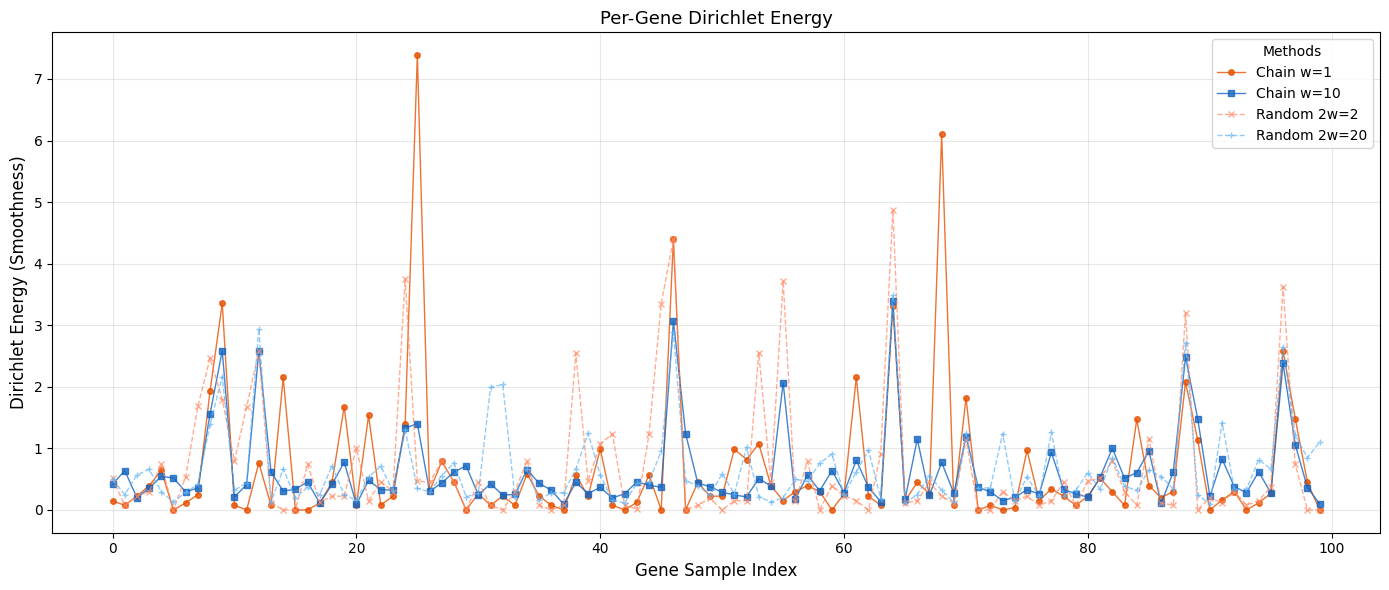


--- Single cell (cell 0) statistics ---
Chain w= 1: mean = 0.6729, std = 1.1796
Random 2w= 2: mean = 0.6955, std = 1.0483
Chain w=10: mean = 0.6264, std = 0.6467
Random 2w=20: mean = 0.6696, std = 0.6708

=== PLOT 2: Box plots over 1000 cells ===


Processing cells: 100%|██████████| 1000/1000 [00:05<00:00, 191.46it/s]
/local/user/1483802485/ipykernel_78581/1927265572.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)


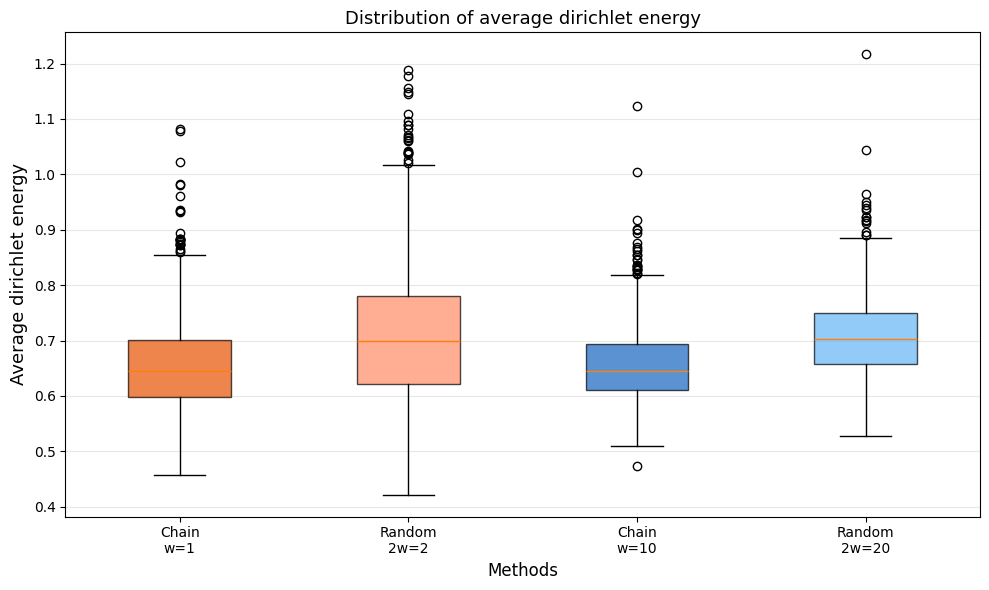


--- Box plot statistics over 1000 cells ---
Chain w= 1: mean = 0.6548, std = 0.0857
Random 2w= 2: mean = 0.7088, std = 0.1243
Chain w=10: mean = 0.6557, std = 0.0677
Random 2w=20: mean = 0.7081, std = 0.0732


In [4]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from tqdm import tqdm

def calculate_local_dirichlet(data, gene_idx, window, n_genes):
    """Compute Dirichlet energy for a single gene with its w-neighbors (chain/positional).
    
    data: expression vector for one cell (shape: n_genes,)
    gene_idx: the center gene index
    window: how many neighbors on each side
    n_genes: total number of genes
    """
    # Get neighbor indices (positional neighbors in the chain)
    left = max(0, gene_idx - window)
    right = min(n_genes, gene_idx + window + 1)
    neighbors = [j for j in range(left, right) if j != gene_idx]
    
    if len(neighbors) == 0:
        return 0.0
    
    # Squared differences between gene_idx and its neighbors
    center_val = data[gene_idx]
    diffs_sq = [(center_val - data[j])**2 for j in neighbors]
    return np.mean(diffs_sq)

def calculate_random_dirichlet(data, gene_idx, n_random, n_genes, rng):
    """Compute Dirichlet energy for a single gene with randomly sampled genes.
    
    data: expression vector for one cell (shape: n_genes,)
    gene_idx: the center gene index
    n_random: number of random genes to sample (2*w)
    n_genes: total number of genes
    rng: numpy random generator for reproducibility
    """
    # Sample random gene indices (excluding the center gene)
    all_other_genes = np.concatenate([np.arange(0, gene_idx), np.arange(gene_idx + 1, n_genes)])
    neighbors = rng.choice(all_other_genes, size=min(n_random, len(all_other_genes)), replace=False)
    
    if len(neighbors) == 0:
        return 0.0
    
    # Squared differences between gene_idx and random neighbors
    center_val = data[gene_idx]
    diffs_sq = [(center_val - data[j])**2 for j in neighbors]
    return np.mean(diffs_sq)

# 1. Load Data
adata = sc.read_h5ad("/home/b5cc/sanjukta.b5cc/aracneseq/datasets/k562_5k.h5ad")
n_genes = adata.shape[1]
n_cells = adata.shape[0]

print(f"Data shape: {n_cells} cells × {n_genes} genes")

# 2. Normalize the data
print("Normalizing data...")
# Library size normalization (normalize to 10,000 counts per cell)
sc.pp.normalize_total(adata, target_sum=1e4)
# Log1p transformation
sc.pp.log1p(adata)
print("Applied: normalize_total (target_sum=10000) + log1p")

# Convert to dense array
if scipy.sparse.issparse(adata.X):
    X = adata.X.toarray()
else:
    X = adata.X

# 3. Randomly sample 100 gene indices
np.random.seed(42)  # For reproducibility
n_samples = 100
sampled_genes = np.random.choice(n_genes, size=n_samples, replace=False)

print(f"Sampled {n_samples} random gene indices")

# 4. Window sizes to test (only w=1 and w=10)
window_sizes = [1, 10]

# Create a separate RNG for random sampling (for reproducibility)
rng = np.random.default_rng(seed=123)

# ============================================================
# PLOT 1: Single cell - per-gene Dirichlet energy (no averaging)
# ============================================================
print("\n=== PLOT 1: Single cell analysis ===")
single_cell_idx = 0  # Pick cell 0

# Compute per-gene Dirichlet energy for single cell
single_cell_chain = {w: [] for w in window_sizes}
single_cell_random = {w: [] for w in window_sizes}

cell_data = X[single_cell_idx, :]

for gene_idx in sampled_genes:
    for w in window_sizes:
        # Chain/positional neighbors
        energy_chain = calculate_local_dirichlet(cell_data, gene_idx, w, n_genes)
        single_cell_chain[w].append(energy_chain)
        
        # Random neighbors (2*w genes)
        energy_random = calculate_random_dirichlet(cell_data, gene_idx, 2*w, n_genes, rng)
        single_cell_random[w].append(energy_random)

# Plot 1: Single cell per-gene smoothness
fig, ax = plt.subplots(figsize=(14, 6))

colors_chain = {'1': '#E65100', '10': '#1565C0'}  # Orange, Blue for chain
colors_random = {'1': '#FF8A65', '10': '#64B5F6'}  # Lighter versions for random
markers_chain = {'1': 'o', '10': 's'}
markers_random = {'1': 'x', '10': '+'}

# Plot chain-based results (solid lines)
for w in window_sizes:
    ax.plot(range(n_samples), single_cell_chain[w], 
            marker=markers_chain[str(w)], linestyle='-', alpha=0.8,
            color=colors_chain[str(w)], label=f'Chain w={w}', markersize=4, linewidth=1)

# Plot random-based results (dashed lines)
for w in window_sizes:
    ax.plot(range(n_samples), single_cell_random[w], 
            marker=markers_random[str(w)], linestyle='--', alpha=0.7,
            color=colors_random[str(w)], label=f'Random 2w={2*w}', markersize=5, linewidth=1)

ax.set_xlabel('Gene Sample Index', fontsize=12)
ax.set_ylabel('Dirichlet Energy (Smoothness)', fontsize = 12)
ax.set_title(f'Per-Gene Dirichlet Energy', fontsize=13)
ax.legend(title='Methods',loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("plot1_single_cell_dirichlet.png", dpi=180)
plt.show()

# Print stats for single cell
print(f"\n--- Single cell (cell {single_cell_idx}) statistics ---")
for w in window_sizes:
    print(f"Chain w={w:2d}: mean = {np.mean(single_cell_chain[w]):.4f}, std = {np.std(single_cell_chain[w]):.4f}")
    print(f"Random 2w={2*w:2d}: mean = {np.mean(single_cell_random[w]):.4f}, std = {np.std(single_cell_random[w]):.4f}")

# ============================================================
# PLOT 2: Box plots over 1000 cells
# ============================================================
print("\n=== PLOT 2: Box plots over 1000 cells ===")
n_cells_sample = min(1000, n_cells)  # Sample up to 1000 cells
cell_indices = np.random.choice(n_cells, size=n_cells_sample, replace=False)

# For each cell, compute the average Dirichlet energy across all sampled genes
# Store: cell_avg_chain[w] = list of average energies per cell
# Store: cell_avg_random[w] = list of average energies per cell
cell_avg_chain = {w: [] for w in window_sizes}
cell_avg_random = {w: [] for w in window_sizes}

rng2 = np.random.default_rng(seed=456)  # Fresh RNG for plot 2

for cell_idx in tqdm(cell_indices, desc="Processing cells"):
    cell_data = X[cell_idx, :]
    
    for w in window_sizes:
        gene_energies_chain = []
        gene_energies_random = []
        
        for gene_idx in sampled_genes:
            # Chain/positional neighbors
            energy_chain = calculate_local_dirichlet(cell_data, gene_idx, w, n_genes)
            gene_energies_chain.append(energy_chain)
            
            # Random neighbors (2*w genes)
            energy_random = calculate_random_dirichlet(cell_data, gene_idx, 2*w, n_genes, rng2)
            gene_energies_random.append(energy_random)
        
        # Average over genes for this cell
        cell_avg_chain[w].append(np.mean(gene_energies_chain))
        cell_avg_random[w].append(np.mean(gene_energies_random))

# Prepare data for box plots
box_data = []
box_labels = []

for w in window_sizes:
    box_data.append(cell_avg_chain[w])
    box_labels.append(f'Chain\nw={w}')
    box_data.append(cell_avg_random[w])
    box_labels.append(f'Random\n2w={2*w}')

# Plot 2: Box plots
fig, ax = plt.subplots(figsize=(10, 6))

colors_box = ['#E65100', '#FF8A65', '#1565C0', '#64B5F6']  # Orange chain, Orange random, Blue chain, Blue random

bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)

for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Average dirichlet energy',fontsize = 13)
ax.set_xlabel('Methods', fontsize=12)
ax.set_title(f'Distribution of average dirichlet energy',fontsize = 13) 
ax.grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.savefig("plot2_boxplot_1000cells.png", dpi=180)
plt.show()

# Print stats for box plots
print(f"\n--- Box plot statistics over {n_cells_sample} cells ---")
for w in window_sizes:
    print(f"Chain w={w:2d}: mean = {np.mean(cell_avg_chain[w]):.4f}, std = {np.std(cell_avg_chain[w]):.4f}")
    print(f"Random 2w={2*w:2d}: mean = {np.mean(cell_avg_random[w]):.4f}, std = {np.std(cell_avg_random[w]):.4f}")